#                                       Lisbon Properties

November 12, 2021

# Introduction

Lisbon is a city that has been standing out more and more among other European capitals for its beaches, weather, gastronomy, among other factors. The real estate market in Lisbon district is also on the rise and Portugal has been receiving more and more tourists in the recent years, who see Portugal as a possible destination to retirement. For these reasons, in this project, I decided to explore the real estate market in the district of Lisbon in a deeper way. As this is the first part of my project, on this notebook, I will carry out an exploratory analysis on a website which belongs to a Portuguese real estate company - "Imovirtual" - that contains advertisements of flats that are in the current market for sale.

Regarding the second part of my project, without going into much detail, I intend to build a model that forecasts the current selling price of each apartment or even predict possible changes in sales prices over the months, based on previous ones, and also discover and predict the most profitable flats that can become potential products for the purchase and resale market or other possibilities. This last idea arose based on the fact that, in recent years, many investors have been investing in old or underpriced flats, renovating them and opening airbnb businesses or profiting from resaling them.

###### Note: all websites used in this project were able and allowed to be scrapped by terms and conditions and all the tables collect from the internet are public

# Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from geopy.geocoders import Nominatim
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Data extraction

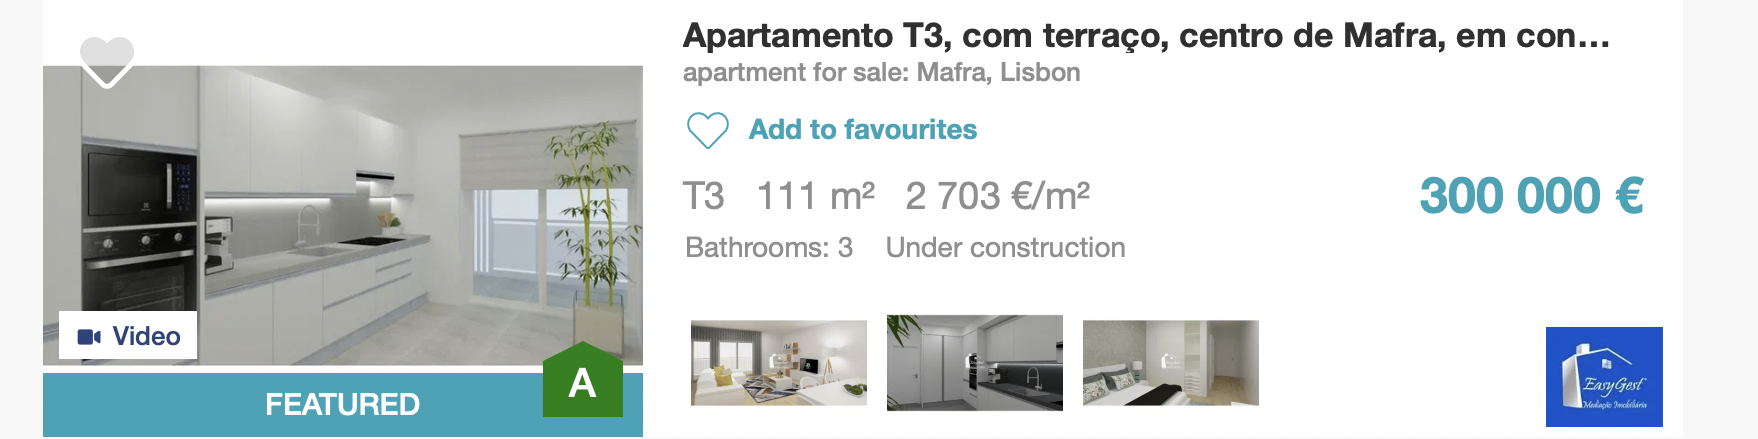

Regarding to data extraction, each page on the website used to get information about existing flats in the current real estate market, contained 72 articles, each one with information relating to the flat in question, to get this information, I used the Web Scraping method, where I used request library to obtain information and  beautifulsoup library to make the information more readable.
In this process, I needed to go to each page of the website and insisde each one, get each article (you can see how each article look in the image above) and get the information related to the flat in question.

In [ ]:
url = 'https://www.imovirtual.com/en/comprar/apartamento/lisboa/?search%5Bregion_id%5D=11&nrAdsPerPage=72'

In [ ]:
response = requests.get(url)
response

Response 200 indicates that the request has succeeded and we get the information 

### Now, we are going to get the first 100 pages of our website, remembering that each one has 72 articles, and  we going to put them into a list to be possible, after, get inside of each page and take the articles

In [ ]:
list_of_pages = []
for number in range(2,101): #give me the frist 100 pages
    list_of_pages.append(url+'&page='+str(number))
list_of_pages.insert(0,url) #to get the first page in the first position of the list


### Once this is done, We can get  the information from each flat

For that, we will use lists, which will later be used to build our data frame, soup_findall() function to find the classes of features we want to get, regex() library to clean obtained information, list comprehensitions to avoid extensive For Loops and other functions like split() to manage some details

In [ ]:
URL = []
price = []
typology  = []
area = []
concelhos =[]
freguesias = []
bathrooms = []
conditions = []
valid_conditions = ['Used', 'Renovated', 'New','Under construction','To recuperate']
valid_bathrooms = ['Bathrooms: 1','Bathrooms: 2','Bathrooms: 3','Bathrooms: 4','Bathrooms: 4 or more'] 


#returns list of all articles/flats in the current page

for page in list_of_pages:
    print(page)
    response = requests.get(page)
    soup = BeautifulSoup(response.content)
    
    articles = soup.find_all(attrs = {'class' : re.compile('(offer-item ad_id)')}) # re.complile() because the class name is different for each article
    
    URL.append([flat.a['href'] for flat in articles])
    price.append([flat.find_all(attrs = {'class': 'offer-item-price'})[0].text.split('\n')[-1].replace('€ ','').replace(' ','') for flat in articles])
    typology.append([flat.find_all(attrs = {'class': 'offer-item-rooms hidden-xs'})[0].text for flat in articles])
    concelhos.append([flat.find_all(attrs = {'class': 'text-nowrap'})[1].text.split(" ")[-2].replace(",","")  for flat in articles])
    freguesias.append([flat.find_all(attrs = {'class': 'text-nowrap'})[1].text.split(" ")[-3].replace(",","")  for flat in articles])
    area.append([float(flat.find_all(attrs = {'class': 'hidden-xs offer-item-area'})[0].text.replace(' m²','').replace(',','.').replace(' ',''))for flat in articles])  


# The condition and number of bathrooms of flats can be found in two distinct classes, some properties have one type of formatting, others another.
# To manage this, we had to use try, except to handle both cases

    for flat in articles:
        try:
            class_ = flat.find_all(attrs = {'class' : 'parameters-view hidden-xs'})[0]
            condition = [condition.text for condition in class_.find_all('li')][-1]
            if condition in valid_conditions:
                conditions.append(condition)
            else:
                condition = [condition.text for condition in class_.find_all('li')][-2]
                if condition in valid_conditions:
                    conditions.append(condition)
                else:
                    conditions.append(None)
        except:
            try:
                class_ = flat.find_all(attrs = {'class' : 'params-small clearfix hidden-xs'})[0]
                condition = [condition.text for condition in class_.find_all('li')][-2]
                if condition in valid_conditions:
                    conditions.append(condition)
                else:
                    condition = [condition.text for condition in class_.find_all('li')][-1]
                    if condition in valid_conditions:
                        conditions.append(condition)
                    else:
                        conditions.append(None)      
            except:
                conditions.append(None)
        
        try:
            class_ = flat.find_all(attrs = {'class' : 'parameters-view hidden-xs'})[0]
            bathroom = [bathroom.text for bathroom in class_.find_all('li')][0]
            if bathroom in valid_bathrooms:
                bathrooms.append(bathroom)
            else:
                bathroom = [bathroom.text for bathroom in class_.find_all('li')][-1]
                if bathroom in valid_bathrooms:
                    bathrooms.append(bathroom)
                else:
                    bathrooms.append(None)
        except:
            try:
                class_ = flat.find_all(attrs = {'class' : 'params-small clearfix hidden-xs'})[0]
                bathroom = [bathroom.text for bathroom in class_.find_all('li')][0]
                if bathroom in valid_bathrooms:
                    bathrooms.append(bathroom)
                else:
                    bathroom = [bathroom.text for bathroom in class_.find_all('li')][-1]
                    if bathroom in valid_bathrooms:
                        bathrooms.append(bathroom)
                    else:
                        bathrooms.append(None)
            except:
                bathrooms.append(None)
                

# We use [-1] or [-2] because the condition and bathroom can be in -1 or in -2 positions (Look at the image above)


### Build the data frame

In [ ]:
df = pd.DataFrame()

df['Link'] = [item for list_ in URL for item in list_]
df['Concelho'] = [item for list_ in concelhos for item in list_]
df['Freguesia'] = [item for list_ in freguesias for item in list_]
df['Price'] = [item for list_ in price for item in list_]
df['Bedrooms'] = [item for list_ in typology for item in list_]
df['Area (m²)'] = [item for list_ in area for item in list_]
df['Condition'] = conditions
df['Bathrooms'] = bathrooms

In [ ]:
df.isna().sum()

### Confirm if Web Scraping was well done looking at shape of the data frame and one random flat link to compare features extracted with the real ones

In [ ]:
assert df.shape == (7200,8)
#df['Link'][0]


In [ ]:
df.head()

### To proceed with our exploratory analysis, we are going to use a data frame already saved before which belongs to the file named "house.csv"

In [ ]:
#df.to_csv ('house.csv', index=False)

# 2. Exploratory analysis



##### Important note: In this analysis, we are going to use the portuguese designation for locations (Concelho, Freguesia) as it is more convenient to manipulate the data since all the websites used to get information about locations are portuguese. At some point, we going to change it to english designation but until that, bare in mind that  "Concelhos" are  Sub-districts of the Lisbon District and "Freguesias" are boroughs, sub-districts small areas.

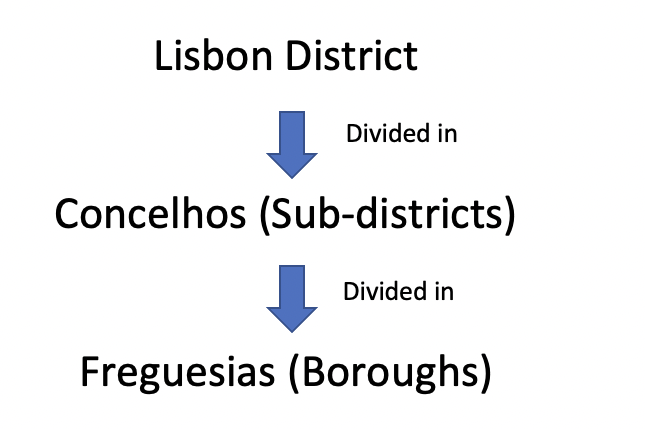

In [2]:
houses = pd.read_csv('house.csv')
houses.head()

,Link,Concelho,Freguesia,Price,Bedrooms,Area (m²),Condition,Bathrooms
0,https://www.imovirtual.com/en/anuncio/t1-proxi...,Amadora,Nova,142500,T2,65.0,Renovated,Bathrooms: 1
1,https://www.imovirtual.com/en/anuncio/t2-novo-...,Lisboa,Arroios,765000,T2,125.0,NaN,Bathrooms: 2
2,https://www.imovirtual.com/en/anuncio/apartame...,Amadora,Nova,258000,T3,99.0,NaN,Bathrooms: 2
3,https://www.imovirtual.com/en/anuncio/fabuloso...,Cascais,Estoril,1380000,T3,160.0,New,Bathrooms: 3
4,https://www.imovirtual.com/en/anuncio/apartame...,Sintra,Martins,190000,T2,85.0,Renovated,Bathrooms: 2


## Data Cleaning

In [3]:
houses.shape

(7200, 8)

In [4]:
houses.isna().sum()

Link            0
Concelho        0
Freguesia       0
Price           0
Bedrooms        0
Area (m²)       0
Condition    1032
Bathrooms     535
dtype: int64

In [5]:
houses['Concelho'].unique()

array(['Amadora', 'Lisboa', 'Cascais', 'Sintra', 'Mafra', 'Oeiras',
       'Loures', 'Odivelas', 'Xira', 'Lourinhã', 'Cadaval', 'Vedras',
       'Azambuja', 'Agraço', 'Alenquer'], dtype=object)

In [6]:
len(houses['Concelho'].unique())

15

In [7]:
houses['Concelho'].value_counts()

Lisboa      3940
Cascais      667
Oeiras       575
Amadora      503
Sintra       493
Odivelas     275
Loures       272
Xira         198
Mafra        167
Lourinhã      64
Vedras        27
Cadaval        8
Alenquer       7
Azambuja       2
Agraço         2
Name: Concelho, dtype: int64

### We can see that some sub-districts (Concelhos), such "Agraço",  have few number of flats so it's probable that these lines will be removed in the future to avoid biased findings

In [8]:
houses['Freguesia'].unique()

array(['Nova', 'Arroios', 'Estoril', 'Martins', 'Ericeira', 'Galés',
       'Caxias', 'Belém', 'Mouro', 'sale:', 'Areeiro', 'Rana', 'Novas',
       'Benfica', 'Maior', 'Queijas', 'Lumiar', 'António', 'Carnide',
       'Velho', 'Abraão', 'Campolide', 'Alvalade', 'Livres',
       'Misericórdia', 'Mira-Sintra', 'França', 'Alfragide', 'Olivais',
       'Cambra', 'de', 'Venteira', 'Nações', 'Ourique', 'Belas', 'Água',
       'Estrela', 'Quebrada-Dafundo', 'Beato', 'Marvila', 'Alcântara',
       'Salvo', 'Parede', 'Caneças', 'Bobadela', 'Alcabideche', 'Vicente',
       'Frielas', 'Tojal', 'Ajuda', 'Marcos', 'Sol', 'Clara', 'Basto',
       'Apelação', 'Atalaia', 'Moniz', 'Penaferrim)', 'Cercal', 'Torres',
       'Portela', 'Bucelas', 'Barcarena', 'Rosário', 'Famões',
       'Carvoeira', 'Cima', 'Fanhões', 'Vimeiro', 'Monte', 'Abelheira',
       'Triana)', 'Cadafais', 'Alcainça', 'Montelavar', 'Lousa',
       'Marteleira', 'Gavinha'], dtype=object)

In [9]:
len((houses['Freguesia'].unique()))

78

In [10]:
houses['Freguesia'].value_counts()

Novas      509
Estoril    403
Belém      271
Arroios    265
Estrela    260
          ... 
Vimeiro      2
Fanhões      1
Lousa        1
Cima         1
Gavinha      1
Name: Freguesia, Length: 78, dtype: int64

### As sub-districts (Concelhos), the same happens to boroughs (Freguesias) so it's probable that some boroughs will be removed in the future to avoid misleading conclusions

In [11]:
houses['Bedrooms'].unique()

array(['T2', 'T3', 'T1', 'T6', 'T5', 'T4', 'T0', 'T7', 'T10 or higher',
       'T8', 'T9'], dtype=object)

In [12]:
houses['Bedrooms'].value_counts()

T2               2434
T3               2371
T1               1095
T4                851
T5                218
T0                150
T6                 47
T7                 16
T9                  8
T8                  6
T10 or higher       4
Name: Bedrooms, dtype: int64

### When doing  web scrapping, noticed that from 6 rooms onwards, a higher number of rooms does not differentiate as much in price from other flats with 6 rooms, therefore, as we have few flats with more than 6 rooms, we will transform them into 6 bedrooms flats

In [13]:
houses['Bedrooms']=houses['Bedrooms'].replace({'T0':0, 'T1':1, 'T2':2, 'T3':3, 'T4':4,'T5':5,'T6':6,'T7':6,'T8':6,'T9':6,'T10 or higher':6})


In [14]:
houses['Price'].unique()

array(['142500', '765000', '258000', ..., '89000', '86500', '428400'],
      dtype=object)

### When doing web scraping, also noticed that some flats have the selling price as 'Priceondemand' so we going to replace the lines of price column, where this happens, to None

In [15]:
houses[houses['Price'] == 'Priceondemand'].head()

,Link,Concelho,Freguesia,Price,Bedrooms,Area (m²),Condition,Bathrooms
218,https://www.imovirtual.com/en/anuncio/espectac...,Lisboa,Belém,Priceondemand,4,257.14,New,Bathrooms: 4 or more
332,https://www.imovirtual.com/en/anuncio/apartame...,Lisboa,Estrela,Priceondemand,2,110.00,Under construction,Bathrooms: 2
408,https://www.imovirtual.com/en/anuncio/apartame...,Oeiras,Caxias,Priceondemand,4,192.00,Under construction,Bathrooms: 4 or more
409,https://www.imovirtual.com/en/anuncio/apartame...,Oeiras,Caxias,Priceondemand,5,226.00,Under construction,Bathrooms: 4 or more
410,https://www.imovirtual.com/en/anuncio/apartame...,Oeiras,Caxias,Priceondemand,3,176.00,Under construction,Bathrooms: 4 or more


In [16]:
len(houses[houses['Price'] == 'Priceondemand'])

56

In [17]:
houses['Price'].replace('Priceondemand',None,inplace=True) #inplace=True para esta transformação ocorra no df original

### Eliminate nulls

In [18]:
houses.dropna(axis=0,inplace=True)
houses.shape

(5658, 8)

In [19]:
houses.isna().sum()

Link         0
Concelho     0
Freguesia    0
Price        0
Bedrooms     0
Area (m²)    0
Condition    0
Bathrooms    0
dtype: int64

In [20]:
houses['Condition'].unique()

array(['Renovated', 'New', 'Used', 'Under construction', 'To recuperate'],
      dtype=object)

In [21]:
houses['Condition'].value_counts()

New                   1779
Used                  1662
Under construction    1138
Renovated             1008
To recuperate           71
Name: Condition, dtype: int64

### We can see that there are only 71 flats with the condition 'To recuperate' which compared to the other numbers is an extremely small, so let's eliminate these lines.

For this, we going to use the loc function to find the lines where this happens, take the index of each one and eliminate them


In [22]:
houses.drop(houses.loc[houses['Condition']=='To recuperate'].index, inplace=True)

In [23]:
houses['Bathrooms'].unique()

array(['Bathrooms: 1', 'Bathrooms: 3', 'Bathrooms: 2',
       'Bathrooms: 4 or more'], dtype=object)

### When doing web scraping bathrooms came in this format "Bathrooms: 1", so we going to convert that to integers

In [24]:
houses['Bathrooms']=houses['Bathrooms'].replace({'Bathrooms: 1':1, 'Bathrooms: 3':3, 'Bathrooms: 2':2,
       'Bathrooms: 4 or more':4})

### Also during web scraping, noticed that very few apartments have size area greater than 500 squared meters, so let's eliminate these lines as there are not as many compared to the total number of the lines


In [25]:
len(houses.loc[houses['Area (m²)']>500])

16

In [26]:
houses.drop(houses.loc[houses['Area (m²)']>500].index, inplace=True)


In [27]:
houses.head()

,Link,Concelho,Freguesia,Price,Bedrooms,Area (m²),Condition,Bathrooms
0,https://www.imovirtual.com/en/anuncio/t1-proxi...,Amadora,Nova,142500,2,65.0,Renovated,1
3,https://www.imovirtual.com/en/anuncio/fabuloso...,Cascais,Estoril,1380000,3,160.0,New,3
4,https://www.imovirtual.com/en/anuncio/apartame...,Sintra,Martins,190000,2,85.0,Renovated,2
5,https://www.imovirtual.com/en/anuncio/apartame...,Mafra,Ericeira,385000,2,100.0,Used,2
6,https://www.imovirtual.com/en/anuncio/exclusiv...,Mafra,Galés,225000,2,107.0,Used,2


## Colecting additional info - Sub-districts (Concelhos)

### Let's analyze the sub-districts (Concelhos) of Lisbon District
 For this we will use the https://pt.wikipedia.org/wiki/Distrito_de_Lisboa

In [28]:
tables = pd.read_html('https://pt.wikipedia.org/wiki/Distrito_de_Lisboa')


In [29]:
lisbon_concelhos = tables[4]
lisbon_concelhos

,Brasão,Município,Área (km²),População (hab.)[4],Densidade pop. (hab./km²),N.º freguesias [5]
0,NaN,Alenquer,30422,44 428,14604,11
1,NaN,Amadora,2379,171 719,"7 218,12",6
2,NaN,Arruda dos Vinhos,7796,13 983,17936,4
3,NaN,Azambuja,26266,21 421,8155,7
4,NaN,Cadaval,17489,13 382,7652,7
5,NaN,Cascais,9740,214 134,"2 198,5",4
6,NaN,Lisboa,10005,544 851,"5 445,79",24
7,NaN,Loures,16724,201 646,"1 205,73",10
8,NaN,Lourinhã,14717,26 261,17844,8
9,NaN,Mafra,29166,89 130,28502,11


### Note that in this data frame the 'Municipio' is the same as 'Concelho', remembering that  Concelhos are the Sub-districts of the Lisbon District and Freguesias are the boroughs, sub-districts small areas

### Eliminate unnecessary columns

In [30]:
lisbon_concelhos.drop(['Brasão','Densidade pop. (hab./km²)','N.º freguesias [5]','Área (km²)'], axis=1, inplace=True)

In [31]:
lisbon_concelhos.rename(columns={'Município': 'Concelho','População (hab.)[4]':'Total Population'}, inplace = True)

In [32]:
lisbon_concelhos

,Concelho,Total Population
0,Alenquer,44 428
1,Amadora,171 719
2,Arruda dos Vinhos,13 983
3,Azambuja,21 421
4,Cadaval,13 382
5,Cascais,214 134
6,Lisboa,544 851
7,Loures,201 646
8,Lourinhã,26 261
9,Mafra,89 130


### Sometimes the web scraping can come with some erros related to the  words endings or beginnings, so let's check if the names of sub-districts (Concelhos) match the real names 

In [33]:
houses['Concelho'].unique()

array(['Amadora', 'Cascais', 'Sintra', 'Mafra', 'Oeiras', 'Lisboa',
       'Loures', 'Xira', 'Odivelas', 'Lourinhã', 'Cadaval', 'Vedras',
       'Azambuja', 'Agraço', 'Alenquer'], dtype=object)

In [34]:
houses['Concelho'].replace({'Xira': 'Vila Franca de Xira','Agraço':'Sobral de Monte Agraço','Vedras':'Torres Vedras','Lisboa':'Lisbon'},inplace=True)
lisbon_concelhos['Concelho'].replace({'Lisboa':'Lisbon'},inplace=True)

### Next, we will get the coordinates of the sub-districts (Concelhos) as it can be useful for some analysis or visualization.
For this purpose, we will use a table containing this information, taken from the website https://simplemaps.com/data/pt-cities

In [35]:
coordinates = pd.read_csv('pt.csv')
coordinates

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Lisbon,38.7452,-9.1604,Portugal,PT,Lisboa,primary,506654.0,506654.0
1,Sintra,38.7974,-9.3904,Portugal,PT,Lisboa,minor,377835.0,377835.0
2,Vila Nova de Gaia,41.1333,-8.6167,Portugal,PT,Porto,minor,302295.0,302295.0
3,Porto,41.1495,-8.6108,Portugal,PT,Porto,admin,237591.0,237591.0
4,Braga,41.5333,-8.4167,Portugal,PT,Braga,admin,181494.0,181494.0
...,...,...,...,...,...,...,...,...,...
343,Vizela,41.3828,-8.2647,Portugal,PT,Braga,minor,NaN,NaN
344,Montalegre,41.8239,-7.7900,Portugal,PT,Vila Real,minor,NaN,NaN
345,Alcoutim,37.4717,-7.4722,Portugal,PT,Faro,minor,NaN,NaN
346,Lourinhã,39.2425,-9.3122,Portugal,PT,Lisboa,minor,NaN,NaN


In [36]:
coordinates.rename(columns={'city': 'Concelho'}, inplace = True)

### Merge this table with the previous table

In [37]:
concelhos_info = pd.merge(lisbon_concelhos,coordinates, on='Concelho')
concelhos_info

,Concelho,Total Population,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Alenquer,44 428,39.0531,-9.0092,Portugal,PT,Lisboa,minor,NaN,NaN
1,Amadora,171 719,38.7500,-9.2333,Portugal,PT,Lisboa,minor,175136.0,175136.0
2,Arruda dos Vinhos,13 983,38.9833,-9.0667,Portugal,PT,Lisboa,minor,13391.0,13391.0
3,Azambuja,21 421,39.0667,-8.8667,Portugal,PT,Lisboa,minor,21814.0,21814.0
4,Cadaval,13 382,39.2500,-9.1000,Portugal,PT,Lisboa,minor,14525.0,14525.0
5,Cascais,214 134,38.6972,-9.4217,Portugal,PT,Lisboa,minor,NaN,NaN
6,Lisbon,544 851,38.7452,-9.1604,Portugal,PT,Lisboa,primary,506654.0,506654.0
7,Loures,201 646,38.8309,-9.1684,Portugal,PT,Lisboa,minor,NaN,NaN
8,Lourinhã,26 261,39.2425,-9.3122,Portugal,PT,Lisboa,minor,NaN,NaN
9,Mafra,89 130,38.9333,-9.3333,Portugal,PT,Lisboa,minor,76685.0,76685.0


### Eliminate unnecessary columns

In [38]:
concelhos_info.drop(concelhos_info.iloc[:, 4:], axis=1, inplace = True) #Removing all columns between column index 4 and so on

In [39]:
concelhos_info.head()

,Concelho,Total Population,lat,lng
0,Alenquer,44 428,39.0531,-9.0092
1,Amadora,171 719,38.7500,-9.2333
2,Arruda dos Vinhos,13 983,38.9833,-9.0667
3,Azambuja,21 421,39.0667,-8.8667
4,Cadaval,13 382,39.2500,-9.1000


### Having the information of the sub-districts (Concelhos) let's join this table to my data frame that contains the information of flats

In [40]:
houses_merge_concelhos = pd.merge(houses,concelhos_info, on='Concelho')

In [41]:
houses_merge_concelhos.head()

,Link,Concelho,Freguesia,Price,Bedrooms,Area (m²),Condition,Bathrooms,Total Population,lat,lng
0,https://www.imovirtual.com/en/anuncio/t1-proxi...,Amadora,Nova,142500,2,65.0,Renovated,1,171 719,38.75,-9.2333
1,https://www.imovirtual.com/en/anuncio/4-assoal...,Amadora,Livres,159000,3,76.0,Used,1,171 719,38.75,-9.2333
2,https://www.imovirtual.com/en/anuncio/apartame...,Amadora,Alfragide,170000,3,103.0,Used,2,171 719,38.75,-9.2333
3,https://www.imovirtual.com/en/anuncio/apartame...,Amadora,Venteira,144500,2,65.0,Used,1,171 719,38.75,-9.2333
4,https://www.imovirtual.com/en/anuncio/amadora-...,Amadora,Água,139000,2,60.0,Renovated,1,171 719,38.75,-9.2333


In [42]:
houses_merge_concelhos.rename(columns={'lat': 'Lat', 'lng':'Lng'}, inplace = True)

## Colecting additional info - Crime

### Next, let's explore crime and see if this additional information will play a role in our analysis.
For this, we will use a table taken from the website https://www.pordata.pt/en/DB/Municipalities/Search+Environment/Table

##### Important note : I tried to take the crime of each borough (Freguesia) but it was not possible because it does not exist, the crime statistics websites in Portugal, unfortunately, are not very informative and not very complete.
As we only have information about crime of the sub-districts (Concelhos), it seems that these crime info may not influence as much the current price prediction we will make in the second part of the project since the flats are more specifically related to the boroughs (Freguesias) and here we have a more general information, however, we will look at it later in the analysis

In these analysis, we use 2019 data, as there is no 2021 data and since 2020 was a more unusual year due to covid, in which most of the time we were at home,it is more realistic to use 2019 data.

In [43]:
crime = pd.read_excel('crime_2019.xlsx',
                  usecols= [1,2,3,4,5,6],
                  skiprows = [0,1,2,3,4,5,6,7,8,9,11,12],
                  nrows=9)

FileNotFoundError: [Errno 2] No such file or directory: 'crime_2019.xlsx'

In [ ]:
crime.head() 

In [44]:
crime.rename(columns={'Unnamed: 1': 'Concelho','Total':'Total crime (2019)'}, inplace = True)


NameError: name 'crime' is not defined

In [45]:
crime['Concelho'].replace({'Lisboa':'Lisbon'},inplace=True)

NameError: name 'crime' is not defined

In [46]:
crime

NameError: name 'crime' is not defined

### We can verify that this table does not contain information for all crime categories, just a few, but shows the total number of crimes committed for each sub-district (Concelho).

### Let's explore

In [47]:
total_number_of_crimes_2019 = crime['Total crime (2019)'].sum() 

print('The total number of crimes in Lisbon district in 2019 was: {}' .format(total_number_of_crimes_2019))

NameError: name 'crime' is not defined

We can see that this number is very small considering other capitals in Europe. Portugal is one of the safest countries in the world as we can see on the Forbes website https://www.forbes.com/sites/alexledsom/2020/11/21/the-10-safest-countries-in-the-world-to-visit/?sh=4ca4c8411f74

### Next, let's look at the proportion of each crime category in the total crimes for 2019

In [48]:
proportion_theft_crime_in_total = ((crime['Theft in motor vehicle'].sum()/crime['Total crime (2019)'].sum())*100).round()
print('The proportion of crimes of theft in motor vehicle in the total number of crimes in 2019 was {}' .format(proportion_theft_crime_in_total) + '%')

NameError: name 'crime' is not defined

In [49]:
proportion_domestic_crime_in_total = ((crime['Domestic violence against a spouse or equivalent'].sum()/crime['Total crime (2019)'].sum())*100).round()
print('The proportion of crimes of domestic violence in the total number of crimes in 2019 was {}' .format(proportion_domestic_crime_in_total) + '%')

NameError: name 'crime' is not defined

In [ ]:
proportion_Burglary_in_total = ((crime['Burglary in residence'].sum()/crime['Total crime (2019)'].sum())*100).round()
print('The proportion of crimes of burglary in residence in the total number of crimes in 2019 was {}' .format(proportion_Burglary_in_total) + '%')


In [ ]:
proportion_Burglary_in_total = ((crime['Burglary in commercial or industrial building'].sum()/crime['Total crime (2019)'].sum())*100).round()
print('The proportion of crimes of burglary in commercial or industrial building in the total number of crimes in 2019 was {}' .format(proportion_Burglary_in_total) + '%')



We verify that all the categories presented have a low weight in the total crimes of 2019, but among those we have, the most popular are Domestic violence and Theft in motor vehicle with both 7% of weight in total crime

### Next, let's see which sub-districts have the highest total crimes number and for that we will use the matplotlib library

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(crime['Concelho'],crime['Total crime (2019)'])
plt.xlabel('Concelho')
plt.ylabel('Total crime (2019)')
plt.title ('Total crime per location')
plt.show()

Lisbon is by far the sub-district with the most crime followed by Sintra, all the others have relatively low numbers, being Mafra the sub-district with least crime

Note: Lisbon district has also a sub-district named Lisbon

## Flats data frame - proceed  with the analise and data cleaning

### Once the analysis of the crime is finished, let's go back to our data frame that contains the information on apartments and concelhos

In [ ]:
houses_merge_concelhos.head()

In [ ]:
houses_merge_concelhos['Concelho'].value_counts()


### Eliminate rows with sub-districts value_counts() below 50 to not affect my analysis 

In [ ]:
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Concelho']=='Torres Vedras'].index, inplace=True)
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Concelho']=='Alenquer'].index, inplace=True)
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Concelho']=='Azambuja'].index, inplace=True)
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Concelho']=='Cadaval'].index, inplace=True)
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Concelho']=='Sobral de Monte Agraço'].index, inplace=True)


### Reorder data frame

In [ ]:
houses_merge_concelhos = houses_merge_concelhos[['Lat','Lng','Total Population','Concelho','Link','Freguesia','Price','Area (m²)','Bedrooms','Bathrooms','Condition']]

In [ ]:
houses_merge_concelhos.head()

In [ ]:
houses_merge_concelhos['Freguesia'].value_counts()

We can see that there are boroughs that have a very small number of apartments, so we going to remove these boroughs from our data frame and keep only the ones who have value_counts superior or equal 50

For this, firstly we are going to take the boroughs where this happens using value_counts() function indexes, put them into a list and then remove them from the data frame using a For Loop to scroll through the list, drop() function to remove rows, and loc() function to find the rows of boroughs in the list

In [ ]:
Freguesia_lower_50 = houses_merge_concelhos['Freguesia'].value_counts()[ houses_merge_concelhos['Freguesia'].value_counts() < 50].index.tolist()

In [ ]:
for i in Freguesia_lower_50:
    houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Freguesia']==i].index, inplace=True)


In [ ]:
houses_merge_concelhos['Concelho'].value_counts()

In [ ]:
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Concelho']=='Loures'].index, inplace=True)


In [ ]:
houses_merge_concelhos['Freguesia'].value_counts()

Note: regarding the borougs (Freguesias) as there are some that have long names, when I did the webscrapping some names came incomplete due to the use of functions like split(), so it is necessary to verify some boroughs and eliminate some of them where it was not possible to identify the boroughs, even though it had been checked the flats links in order to figured out the location

In [ ]:
houses_merge_concelhos.loc[houses_merge_concelhos['Freguesia']=='sale:']

In [ ]:
houses_merge_concelhos.loc[houses_merge_concelhos['Freguesia']=='de'].head()

In [ ]:
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Freguesia']=='sale:'].index, inplace=True)
houses_merge_concelhos.drop(houses_merge_concelhos.loc[houses_merge_concelhos['Freguesia']=='de'].index, inplace=True)


### The same we did for the sub-districts (Concelhos), we going to do for the boroughs (Freguesias), verify possible erros related to the  words endings or beginnings which could have came from web scraping and check if the names of boroughs match the real names

For this purpose, we going to use this website https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa to get info about the boroughs (Freguesias) of only lisbon sub-district, remenbering each borough belongs to one sub-district

In [ ]:
tables = pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa')

In [ ]:
freguesias_lisbon_concelho = tables[0]
freguesias_lisbon_concelho.head()

### Table cleaning

In [ ]:
freguesias_lisbon_concelho.columns

In [ ]:
freguesias_lisbon_concelho.drop(['Freguesias antigas'], axis=1, level=0, inplace=True)
freguesias_lisbon_concelho.drop(['Brasão'], axis=1,level=1, inplace=True)
freguesias_lisbon_concelho.drop(['N.º[nota 1]'], axis=1, level=1,inplace=True)
freguesias_lisbon_concelho.drop(['População(2021)[4]'], axis=1, level=1,inplace=True)
freguesias_lisbon_concelho.drop(['Área(km²)[3]'], axis=1, level=1, inplace=True )
freguesias_lisbon_concelho=freguesias_lisbon_concelho.xs('Freguesias atuais', axis=1, drop_level=True)

In [ ]:
freguesias_lisbon_concelho.rename(columns={'Freguesia (Zona)[1]': 'Freguesia'}, inplace=True)

In [ ]:
freguesias_lisbon_concelho.sort_values('Freguesia', inplace = True)
freguesias_lisbon_concelho.drop_duplicates(keep = 'first', inplace = True)

In [ ]:
freguesias_lisbon_concelho.head()

### To capture the information in parentheses, let's create a new column equal to the column "Freguesia"

In [ ]:
freguesias_lisbon_concelho['Orientation']=freguesias_lisbon_concelho['Freguesia']

In [ ]:
freguesias_lisbon_concelho.head()

In [ ]:
freguesias_lisbon_concelho['Freguesia'] = freguesias_lisbon_concelho['Freguesia'].str.replace(r'\(.*\)','')
freguesias_lisbon_concelho['Freguesia'] = freguesias_lisbon_concelho['Freguesia'].str.replace(r'\[.*\]','')
freguesias_lisbon_concelho['Freguesia'] = freguesias_lisbon_concelho['Freguesia'].str.rstrip(' ')
freguesias_lisbon_concelho['Freguesia'] = freguesias_lisbon_concelho['Freguesia'].str.lstrip(' ')

In [ ]:
freguesias_lisbon_concelho.head()

### Get information in parentheses

For this, we going to use lambda function because it can take any number of arguments and apply() function to scroll through all rows in Orientation column. Additionally, we will use functions like split() and replace() to put the words in the most convenient format.

In [ ]:
a = lambda x: str(x).split() 
freguesias_lisbon_concelho['Orientation'] = freguesias_lisbon_concelho['Orientation'].apply(a)

In [ ]:
def Orientation (col):
    return col.apply(lambda x: x[-1])

freguesias_lisbon_concelho['Orientation']= Orientation (freguesias_lisbon_concelho['Orientation'])

In [ ]:
b = lambda x: str(x).replace('(','').replace(')','')

freguesias_lisbon_concelho['Orientation'] = freguesias_lisbon_concelho['Orientation'].apply(b)

In [ ]:
freguesias_lisbon_concelho['Orientation']=freguesias_lisbon_concelho['Orientation'].replace({'Ocidental':'Western', 'Centro':'Center', 'Oriental':'Eastern', 'Norte':'Nortern', 'Historico':'Historic center',
       'Histórico':'Historic center'})

In [ ]:
freguesias_lisbon_concelho.head()

### Once the changes are complete, as mentioned above, let's check the compatibility of the names of the boroughs (Freguesias) in main dataframe (houses_merge_concelhos) and this one and make the necessary changes

In [ ]:
freguesias_lisbon_concelho['Freguesia'].unique()

In [ ]:
houses_merge_concelhos['Freguesia'].unique()

In [ ]:
houses_merge_concelhos['Freguesia'].replace({'António': 'Santo António', 'Novas': 'Avenidas Novas','Ourique':'Campo de Ourique','Maior':'Santa Maria Maior','França':'Penha de França','Vicente':'São Vicente','Nações':'Parque das Nações'}, inplace=True)


In [ ]:
houses_merge_concelhos['Freguesia'].unique()

##### Important note: unfortunately, for the other boroughs belonging to other sub-districts, I didn't find any tables online but as there are few, with the help of this website http://freguesiasdeportugal.com/lisboa-distrito, I made the necessary changes manually

In [ ]:
houses_merge_concelhos['Freguesia'].replace({'Rana':'São Domingos de Rana','Livres':'Águas Livres','Água':'Mina de Água','Martins':'Mem Martins','Salvo':'Porto Salvo'}, inplace=True)


In [ ]:
houses_merge_concelhos.head()

### Given the changes made, let's recheck some general information and visualize others

In [ ]:
houses_merge_concelhos.shape 

In [ ]:
plt.bar(houses_merge_concelhos['Concelho'].value_counts().index,houses_merge_concelhos['Concelho'].value_counts())
plt.xlabel('Concelho')
plt.ylabel('Number of flats')
plt.title ('Number of flats per sub_district')
plt.show()

In [ ]:
houses_merge_concelhos['Freguesia'].unique() 

### To represent the value_counts of the boroughs (Freguesias) we going to use a pie chart since as there are many different boroughs if we use a bar chart, the x axis would be too long and it would not be possible to visualize it without the words being on top of each other.

We start by grouping our data frame by Freguesias and then we use the Link column as our count because it is the only column where all the variables are different, so this new dataframe would match the value_counts of boroughs in our original dataframe

In [ ]:
freguesias = houses_merge_concelhos.groupby('Freguesia').agg({'Link':'count'}).sort_values(by = ['Link'], axis = 0, ascending = False).reset_index()
freguesias.head()

Now we are going to visualize this new dataframe using plot() function and choose a sequential color palette for a better visualization

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18, 18))
theme = plt.get_cmap('YlOrBr_r')
ax1.set_prop_cycle('color', [theme(1. * i / len(freguesias['Freguesia'])) for i in range(len(freguesias['Freguesia']))])
plt.pie(freguesias['Link'],labels=freguesias['Freguesia'])
plt.title ('Proportion of total number of flats per borough')
plt.show()

In [ ]:
plt.bar(houses_merge_concelhos['Condition'].value_counts().index,houses_merge_concelhos['Condition'].value_counts())
plt.xlabel('Condition')
plt.ylabel('Number of flats')
plt.title ('Number of flats per condition')
plt.show()

In [ ]:
plt.bar(houses_merge_concelhos['Bedrooms'].value_counts().index,houses_merge_concelhos['Bedrooms'].value_counts())
plt.xlabel('Bedrooms')
plt.ylabel('Number of flats')
plt.title ('Number of flats per number of bedrooms')
plt.show()

In [ ]:
plt.figure(figsize=(4, 5))
plt.bar(houses_merge_concelhos['Bathrooms'].value_counts().index,houses_merge_concelhos['Bathrooms'].value_counts())
plt.xlabel('Bathrooms')
plt.ylabel('Number of flats')
plt.title ('Number of flats per number of bathrooms')
plt.show()

### Now, let's add to our main data frame the crime information we analyzed earlier

In [ ]:
houses_location_crime = pd.merge(houses_merge_concelhos,crime, on='Concelho')

In [ ]:
houses_location_crime

In [ ]:
houses_location_crime.columns

### Let's reorder the columns taking into account that the crime data is only related to the sub-districts (Concelhos) and not to boroughs (Freguesias)

In [ ]:
df_final = houses_location_crime[['Lat','Lng','Concelho','Total Population','Total crime (2019)','Domestic violence against a spouse or equivalent','Theft in motor vehicle', 'Burglary in residence','Burglary in commercial or industrial building','Link','Freguesia', 'Price','Area (m²)','Bedrooms','Bathrooms','Condition']] #reorder columns
df_final.head()

In [ ]:
df_final.dtypes

### We can verify that price and total population columns have a dtype "object", we need to change these variables to numeric 

Note: I noticed that some prices have decimal places separated by commas and to convert the prices to dtype "float" it is necessary to change these commas to dots, and then do the conversion

In [ ]:
def price (col):
    return col.apply(lambda x: x.replace(',','.'))  

df_final['Price']= price(df_final['Price'])

df_final = df_final.astype({'Price': float})

In [ ]:

def convert (col):
    return col.apply(lambda x: x.replace(' ',''))

df_final['Total Population']= convert (df_final['Total Population'])
df_final = df_final.astype({'Total Population': int})


### Having made the changes, let's create a column with the prices per square meter and round each result to 2 decimal places

In [ ]:
df_final['Price per square meter'] = (df_final['Price']/df_final['Area (m²)']).round(2)


### Reorder columns

In [ ]:
df_final = df_final[['Lat','Lng','Concelho','Total Population','Total crime (2019)','Domestic violence against a spouse or equivalent','Theft in motor vehicle', 'Burglary in residence','Burglary in commercial or industrial building','Link','Freguesia', 'Price','Area (m²)','Price per square meter','Bedrooms','Bathrooms','Condition']] #reorder columns


In [ ]:
df_final.head()

### Now, taking into account the fact that the crime is only related to sub-districts (Concelhos) and not to the boroughs (Freguesias)  and having inferred before that this might not have a great impact on the price of houses, which is what we want to determine in the future, since the information of  flats is more specifically related to the boroughs, we going to verify this deduction 

In [ ]:
df_final['Price'].corr(df_final['Total crime (2019)']) 

As we can see the correlation coefficient r is very close to 0 which indicates almost no linear relationship, positive or negative, between price and crime

### Given this conclusion we going to split the data frame into one just about crime (crime_info_df) and another one with information that will be useful for current price prediction (house_price)

In [ ]:
house_price = df_final[['Concelho','Freguesia', 'Price','Area (m²)','Price per square meter','Bedrooms','Bathrooms','Condition']]
house_price.head()

In [ ]:
crime_info_df = df_final[['Lat','Lng','Concelho','Total Population','Total crime (2019)','Domestic violence against a spouse or equivalent','Theft in motor vehicle', 'Burglary in residence','Burglary in commercial or industrial building']]
crime_info_df.head()

In [ ]:
crime_info_df.dtypes

In [ ]:
crime_info_df = crime_info_df.groupby(['Concelho']).mean()
crime_info_df

### We can noticed that the locations with the more population are generally the locations with highest total number of crimes so let's check it but, this time, using statistics to analyze it in a whole population context 

In [ ]:
stats.pearsonr(crime_info_df['Total Population'],crime_info_df['Total crime (2019)'])

Positive r (0.90) and really close to 1 indicates a positive correlation, where the values of both variables, population and crime, tend to increase together. Since this function also calculates the p-value for no-correlation, as the p-value (0.005) is very small, we reject the null hypothesis, "There is no correlation", and we confirm our assumption.

### Now, to have more realistic view of the sub-districts (Concelhos) we are analyzing, we going to replicate  a map using geopy.geocoders.nominatim and folium libraries

In [ ]:
address = 'Lisbon, Portugal'
geolocator = Nominatim(user_agent='daniela_nogueira') # convert an address into latitude and longitude values
location = geolocator.geocode(address) 
latitude = location.latitude
longitude = location.longitude
map_lisbon = folium.Map(location=[latitude, longitude], zoom_start=12) # map rendering library

# add markers to map
for municipality, lat, lng in zip(df_final['Concelho'],df_final['Lat'], df_final['Lng']):
    label = municipality
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

## Prediction selling price data frame

### Now we going to analyze only the data frame that we will use for the current price prediction in the second part of the project

In [ ]:
house_price.head()

### Until now, we used the portuguese designation for locations (Concelho, Freguesia) as it was more convenient to manipulate the date since all the websites used to withdraw information about them were portuguese. At this point, we can switch to the English terms

In [ ]:
house_price.rename(columns={'Concelho':'Sub-district','Freguesia':'Borough'}, inplace=True)

In [ ]:
house_price.head()

In [ ]:
house_price.shape

### Analyse of feature columns in relation to the price column

### First, I'm going to check the distribution of my price variable

In [ ]:
sns.displot(house_price['Price'], bins=10)  
plt.title('Sale Price')
plt.show()

To avoid skewness, which refers to a distortion that deviates from the symmetrical bell curve or normal distribution, in price column we will use logarithm functions to normalize the data. This transformation will also facilitate future data visualizations

In [ ]:
sns.displot(np.log1p(house_price['Price']), bins=10)
plt.title('Sale Price')
plt.show()

In [ ]:
plt.figure(figsize = (30,20)) 
plt.subplot(2,2,2)
sns.boxplot(x='Sub-district', y=np.log1p(house_price['Price']), data=house_price)

We can verify through the boxplot visualization that Sintra is the region with the lowest average selling price values, followed by Amadora and Odivelas and the two most expensive boroughs are Cascais and Lisbon.
We could also see some outliers in the boroughs Lisbon and Sintra mainly but it is also important highlight the outlier observed in the sub-district of cascais which is well above most of selling prices observed up to Q3, 75% of the data, and it is also the boxplot with the most dispersed data.
We can also observe that the sub-district of Oeiras is the closest to a normal distribution, with the observed values less dispersed.


### Change Condition column categorical variables to  numeric to facilitate future predictions

In [ ]:
house_price['Condition'].unique()

In [ ]:
house_price['Condition'].replace({'New':1, 'Used': 2, 'Renovated': 3,'Under construction':4}, inplace=True)


In [ ]:
house_price.to_csv ('house_price.csv', index=False)

### Get a generalized sense of  numeric variables

In [ ]:
house_price.describe()

### Next, we going to analyze the correlation between numerical variables and see which columns most influence the price

For this, we going to use heatmap() to better visualize it

In [ ]:
mask = np.triu(np.ones_like(house_price.corr(), dtype=bool))
plt.figure(figsize = (20, 10))
sns.heatmap(house_price.corr(),mask =mask, annot = True, cmap="YlGnBu")

plt.show()

### From here, we can see that the condition variable has the least influence on price, so we going eliminate this column

In [ ]:
house_price.drop('Condition', axis=1,inplace=True)

In [ ]:
house_price

Note: of course, at the moment, we have few columns to make a more accurate current price prediction in the future, unfortunately, I had some issues related to web scrapping on getting more information, from the immovirtual website (website used to get flats info) for each apartment and due to the time-frame I had, I couldn't try anymore and I had to move forward with the project (You can see the trying on getting more data in the file called "went_wrong_web_scrappping_additional_columns"). However, I will get more information about each apartment in the second part of the project related for example to the existence of park, garage, balcony and so on.

### To predict the price it is necessary that all variables to be numerical so let's convert the remaining categorical features to dummy variables, the ones that take only the value 0 or 1, using using one-hot encoding

In [ ]:
house_prediction = pd.get_dummies(data=house_price,columns=['Sub-district', 'Borough'],drop_first=True)
house_prediction

## Profitability analysis

Note: throughout the project, I verify some outliers so I decided to carry out an additional analysis in which I investigate the apartments which are being sold for a lower selling price comparing to the average selling prices of each borough. The purpose is to see which apartments would be potentially profitables to invest, maybe renovate and then resell for a highest price and benefit from it or just readjust the selling price. I will look at it in more detail in part two of the project but, for now, I made some exploratory analyse.

In [ ]:
outliers_analyse_df = df_final[['Link','Freguesia', 'Price','Area (m²)','Price per square meter','Bedrooms','Bathrooms','Condition']]
outliers_analyse_df.rename(columns={'Freguesia':'Borough'}, inplace=True)




In [ ]:
outliers_analyse_df.head()

In [ ]:
outliers_analyse_df.shape

### Now, we going to group our data frame by boroughs and bedrooms (variable directly related to the size of flats) to get the average price of the flats in different boroughs for different sizes

In [ ]:
grouped = outliers_analyse_df.groupby(['Borough','Bedrooms']).agg({'Price per square meter':'mean'}).reset_index()
grouped

### Sort the lines in descending order by price per square meter for better analysis

In [ ]:
grouped.sort_values(by = ['Price per square meter'], axis = 0, ascending = False) 

### Merge the two data frames 

In [ ]:
new_df = pd.merge(grouped,outliers_analyse_df, how='inner', left_on=['Borough','Bedrooms'], right_on = ['Borough','Bedrooms'])
new_df

### We verify after the merge that the price per square meter column is divided into two, x and y, the first being related to the average price per square meter related to each borough for the different sizes calculated before

In [ ]:
new_df.rename(columns = {'Price per square meter_x':'Avg_price/Location','Price per square meter_y':'Price per square meter'}, inplace = True)


In [ ]:
useful_df = new_df[['Link','Borough','Price','Area (m²)','Price per square meter','Condition','Bedrooms','Bathrooms','Avg_price/Location']]
useful_df.head()

### Now we are going to add a profitablity column

In [ ]:
useful_df['profitability'] = ((useful_df['Price per square meter']-useful_df['Avg_price/Location'])*useful_df['Area (m²)']).round(2)



In [ ]:
useful_df

### Sort lines in descending order by profitability

In [ ]:
useful_df = useful_df.sort_values(by = ['profitability'],ascending = False) 

### For my analysis only interests the lines with prositive and considerable profitability, so we going to eliminate the lines that have profitability below 50000

In [ ]:
useful_df.drop(useful_df.loc[useful_df['profitability']<=50000].index, inplace=True)
useful_df = useful_df.reset_index(drop=True)
useful_df


### Finally, we going to make an interface so that we can search flats according to location, size, price, bedrooms, bathrooms, condition and get the 5 flats with the highest profitability and look to potential investments

In [ ]:
Locations = [item for item in useful_df['Borough']]
Locations = list(dict.fromkeys(Locations)) #removing duplicates

valid_conditions= [item for item in useful_df['Condition']]
valid_conditions = list(dict.fromkeys(valid_conditions)) 

valid_bathrooms=[1,2,3,4]
valid_bedrooms=[0,1,2,3,4,5,6]



def house_searcher():
    
    x = input('By which category would you like to search? Please enter one of the following: (location, size, price, bedrooms, bathrooms, condition) ').lower()
    
    if x == 'location':
        while True:         
            l = input(f'Please enter the Freguesia in Lisbon District you would like to view. please type one of the following: {Locations}').capitalize()   # Get the input
            if l in Locations:      
                return useful_df[useful_df['Borough'] == l].head(5)
    elif x == 'size':
        while True:
            r = input('Please enter the house size range you would like to search in the form: min_size-max_size ')
            if r != '':
                return useful_df[(float((r.split('-')[0]))<useful_df['Area (m²)'])&(useful_df['Area (m²)']<float(r.split('-')[1]))].head(10)
    elif x == 'condition':
        while True:            
            c = input(f'Please enter what condition house you are looking for from the options (New, Renovated, Used, Under construction) ').capitalize()   # Get the input
            if c in valid_conditions:    
                return useful_df[useful_df['Condition'] == c].head(5)
    elif x == 'price':
        while True:
            p = input('Please enter the price range you would like to search in the form: min_price-max_price ')
            if p != '':
                return useful_df[(float((p.split('-')[0]))<useful_df['Price'])&(useful_df['Price']<float(p.split('-')[1]))].head(10)
    elif x == 'bedrooms':
        while True:             
            t = input('Please enter the number of bedrooms from 0-6, considering 0 bedrooms as a studio ')
            if t in ['0','1','2','3','4','5','6']:      
                return useful_df[useful_df['Bedrooms'] == int(t)].head(5)
    elif x == 'bathrooms':
        while True:             
            t = input('Please enter the number of bathrooms from 1-6 ')
            if t in ['1','2','3','4']:      
                return useful_df[useful_df['Bathrooms'] == int(t)].head(5)
    else:
        print("I didn't get that, can you please double check your input")
        house_searcher()
        

In [ ]:
 house_searcher()
    

In [ ]:
 house_searcher()
    

# Conclusion

To summarise, we verify throughout the exploratory analysis that crime, due to the lack of detailed and more precise information, is a variable that does not significant impact on flats selling price, so it is a variable that we will discard from our future analysis, unless we get more usefull information. We also verified, after a whole exploratory and cleaning processes that the variables that most influence the price are the different locations, sub-districts and boroughs, size of apartments and number of bedrooms and bathrooms. We also conclude that it will be possible to obtain future findings in terms of profitability.

# Future improvements

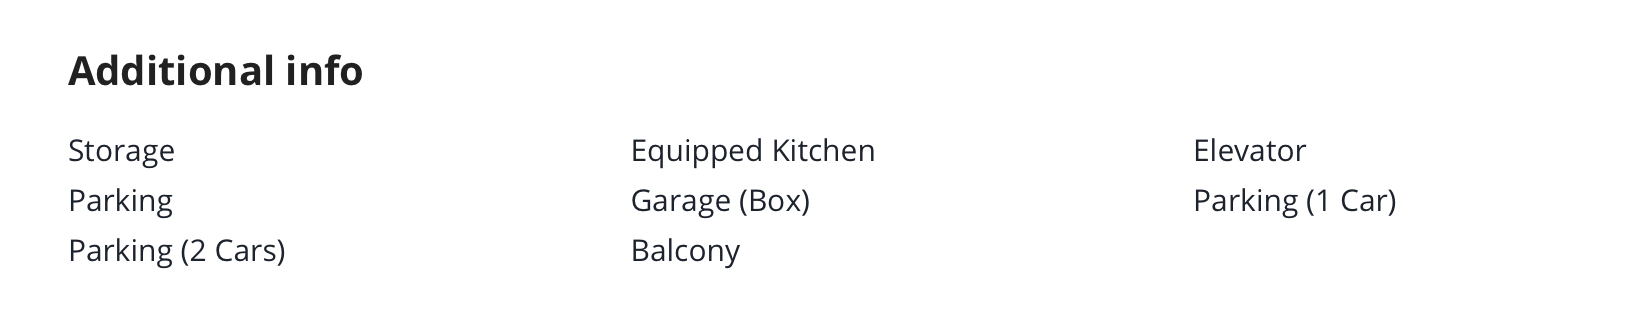

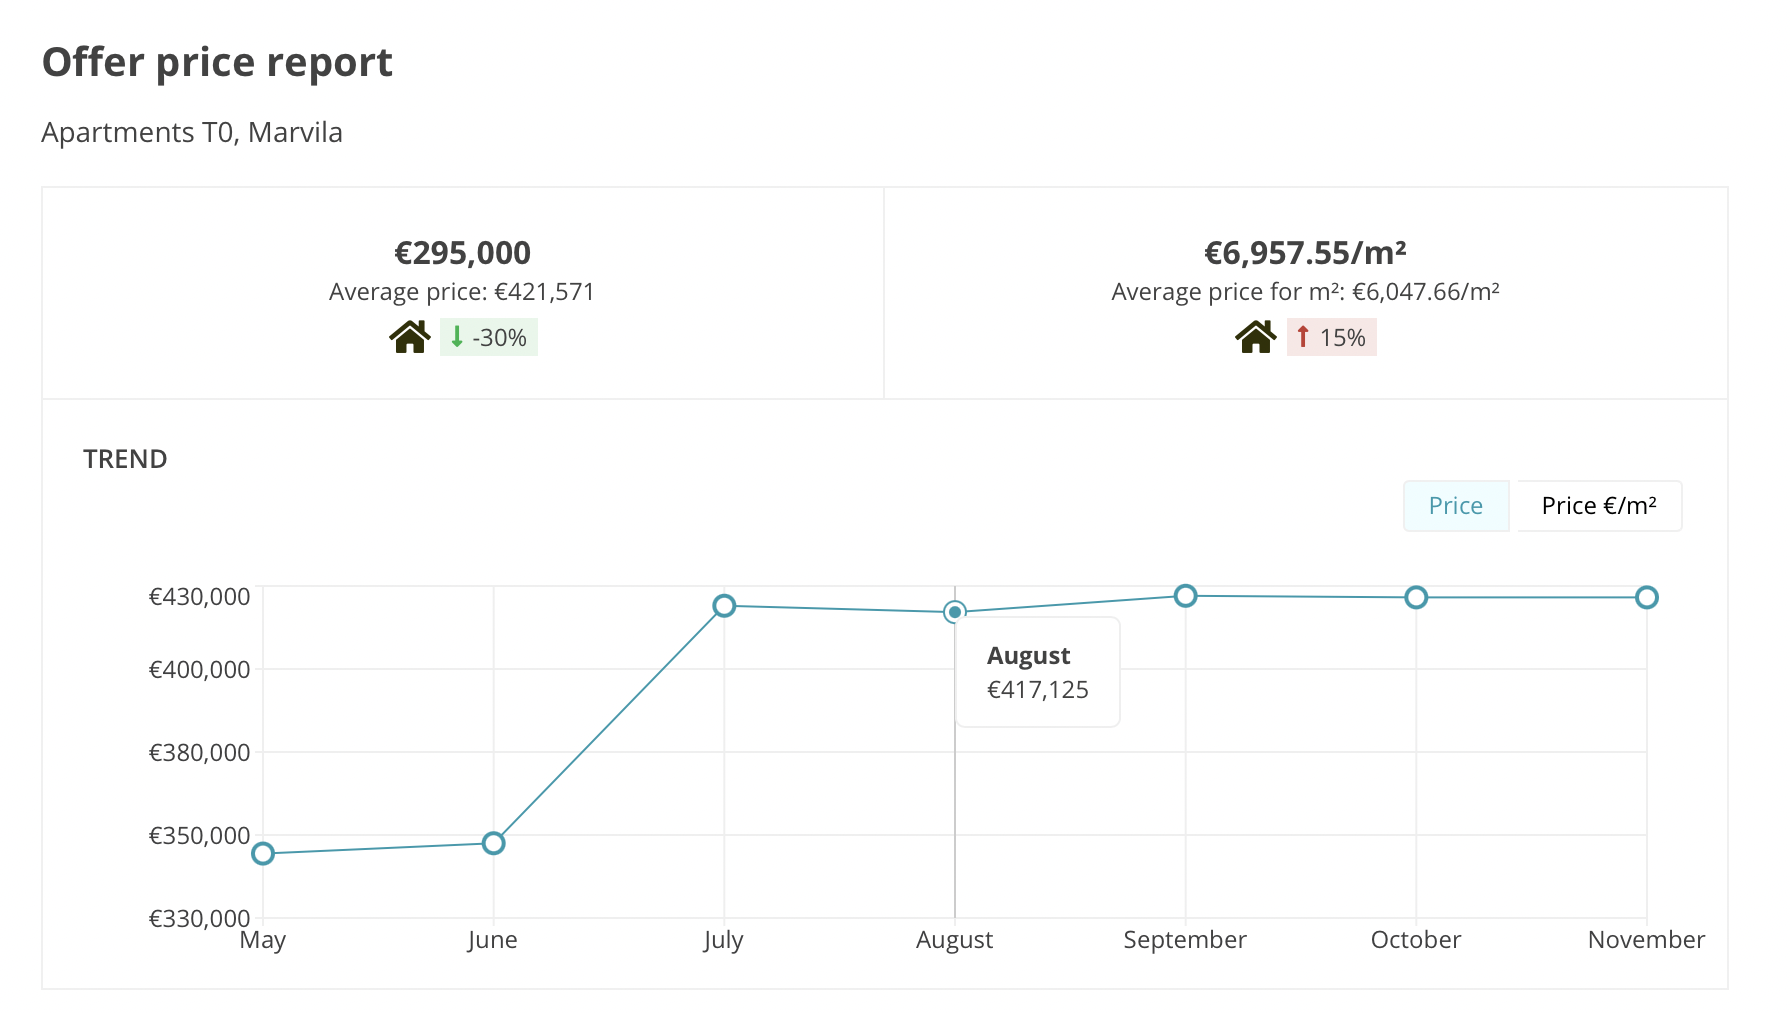

Within each article of each flat, we find additional information regarding the features of flats and the price variation in recent months, as you can see in the images above. Unfortunately, it was not possible, due to the  time  restriction collect these informations, as it demands a more complex web scrapping that would have to be studied in more detail. Given this, in the second part of the project, I intend to obtain more information about each apartment to enrich and give more strength to the model that I will create to forecast the current price and also collect information regarding price changes so that I can create a model for forecast future changes in selling prices for each apartment, based on previous months.

# References

- https://www.kaggle.com/prabhjotkaursethi/house-price-prediction-ridge-and-lasso
- https://www.imovirtual.com/en/comprar/apartamento/lisboa/?search%5Bregion_id%5D=11&nrAdsPerPage=72
- https://pt.wikipedia.org/wiki/Distrito_de_Lisboa
- https://github.com/gusbakker/coursera_capstone
- http://freguesiasdeportugal.com/lisboa-distrito
- https://simplemaps.com/data/pt-cities
- https://pandas.pydata.org/docs/user_guide/index.html
- https://stackoverflow.com